# Weed Detection using Computer Vision

This notebook focuses on developing a weed detection system using computer vision techniques. We are using the "Weed Detection" dataset from Kaggle, which contains images of weed species in agricultural settings.

## Dataset Description
- The dataset consists of annotated images of weed species in various growth stages.
- Images are split into training and test sets
- Annotations are provided in COCO format for object detection

## Objective
The goal is to build and train a model that can accurately detect and localize weed species in images. This has practical applications in precision agriculture and automated weed control systems.

## Approach
We will be using:
- YOLO (You Only Look Once) for object detection
- Data augmentation techniques to improve model robustness
- TensorFlow/Keras for deep learning implementation


In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
%pip install torchmetrics[detection]
%pip install albumentations
%pip install torchvision
%pip install ultralytics
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
import json
import shutil
import yaml
import cv2
import os
from ultralytics import YOLO
import torchvision
import torch
from torchvision.models import resnet50
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from datetime import datetime


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jaidalmotra/weed-detection")
print("Path to dataset files:", path)

100%|██████████| 156M/156M [00:01<00:00, 103MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jaidalmotra/weed-detection/versions/1


# YOLO (You Only Look Once)
In this section, we will:
- Convert our COCO format annotations to YOLO format
- Set up a YOLO model for weed detection 
- Train the model on our dataset
- Evaluate model performance
- Make predictions on test images

YOLO is an efficient real-time object detection system that processes images in a single pass through a neural network, making it ideal for our weed detection task.

In [5]:
# Define paths for train and test data
train_folder = os.path.join(path, 'train')
test_folder = os.path.join(path, 'test')


# Converting COCO Format to YOLO Format

In this step, we'll convert our dataset annotations from COCO format to YOLO format, which is required for training YOLO models.

COCO format uses absolute pixel coordinates in the format:
- `[x, y, width, height]` where (x,y) is the top-left corner
- Separate JSON files containing image info and annotations

YOLO format uses normalized coordinates in a simple text format:
- `<class_id> <x_center> <y_center> <width> <height>`
- All values are normalized between 0 and 1
- One text file per image with the same name

The conversion process will:
1. Read the COCO JSON annotations
2. For each annotation:
   - Convert absolute coordinates to normalized values
   - Convert top-left format to center point format
   - Write in YOLO's text file format



In [6]:
def convert_to_yolo_format(coco_annotations, image_folder, output_folder):
    """
    Convert COCO annotations to YOLO format
    YOLO format: <class> <x_center> <y_center> <width> <height>
    Values are normalized between 0 and 1
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Create mapping of image_id to file_name and dimensions
    image_info = {}
    for img in coco_annotations['images']:
        image_info[img['id']] = {
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height']
        }
    
    # Process each annotation
    current_image_id = None
    current_labels = []
    
    for ann in coco_annotations['annotations']:
        img_id = ann['image_id']
        img_data = image_info[img_id]
        
        # Get bbox coordinates
        x, y, w, h = ann['bbox']
        
        # Convert to YOLO format (normalized)
        x_center = (x + w/2) / img_data['width']
        y_center = (y + h/2) / img_data['height']
        width = w / img_data['width']
        height = h / img_data['height']
        
        # Class ID (assuming category_id starts from 1, YOLO expects 0-based)
        class_id = ann['category_id'] - 1
        
        # Create YOLO format line
        yolo_line = f"{class_id} {x_center} {y_center} {width} {height}"
        
        # Write to file
        label_file = os.path.splitext(img_data['file_name'])[0] + '.txt'
        label_path = os.path.join(output_folder, label_file)
        
        with open(label_path, 'a') as f:
            f.write(yolo_line + '\n')



# Function: visualize_yolo_dataset()

This function visualizes images and their corresponding YOLO format annotations by:
- Taking a directory path containing images and their annotation files
- Randomly selecting a specified number of images (default 3) 
- For each selected image:
  - Loading the image and its YOLO annotation file (.txt)
  - Converting YOLO's normalized coordinates to pixel coordinates
  - Drawing red bounding boxes around the annotated objects
  - Displaying the image with annotations in a subplot

Parameters:
- data_path: Directory containing the image and annotation files
- num_samples: Number of random images to visualize (default=3)

The YOLO annotation format used is:
class_id x_center y_center width height
where all coordinates are normalized between 0 and 1




In [7]:
def visualize_yolo_dataset(data_path, num_samples=3):
    """
    Visualise les images et leurs annotations au format YOLO
    """
    # Charger quelques images aléatoires
    image_files = [f for f in os.listdir(data_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for idx, img_file in enumerate(selected_files):
        # Charger l'image
        img_path = os.path.join(data_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Charger les annotations YOLO correspondantes
        txt_file = os.path.join(data_path, os.path.splitext(img_file)[0] + '.txt')
        
        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(img)
        
        if os.path.exists(txt_file):
            with open(txt_file, 'r') as f:
                lines = f.readlines()
                
            img_height, img_width = img.shape[:2]
            
            for line in lines:
                # Format YOLO: class x_center y_center width height
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                
                # Convertir les coordonnées normalisées en pixels
                x = int((x_center - width/2) * img_width)
                y = int((y_center - height/2) * img_height)
                w = int(width * img_width)
                h = int(height * img_height)
                
                # Dessiner le rectangle
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                plt.gca().add_patch(rect)
                
                # Ajouter le label
                plt.text(x, y-5, f'Weed {class_id}', color='r', fontsize=12)
        
        plt.title(f'Image: {img_file}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Function Documentation

## clean_yolo_annotations(data_path)

This function cleans YOLO annotation files by removing duplicate bounding box annotations.

### Parameters:
- `data_path`: Path to the directory containing YOLO annotation files (.txt)

### Process:
1. Finds all .txt annotation files in the specified directory
2. For each file:
   - Reads all annotation lines
   - Converts annotations to tuples for deduplication
   - Uses a set to identify and remove duplicates
   - Rewrites the file with only unique annotations

### Returns:
- Number of duplicate annotations removed
- Number of files that were cleaned


In [8]:
def clean_yolo_annotations(data_path):
    """
    Nettoie les annotations YOLO en supprimant les doublons
    """
    txt_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]
    duplicates_found = 0
    files_cleaned = 0
    
    for txt_file in txt_files:
        file_path = os.path.join(data_path, txt_file)
        
        # Lire les annotations
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        # Convertir chaque ligne en tuple pour pouvoir utiliser set()
        unique_annotations = set()
        for line in lines:
            # Convertir la ligne en tuple de floats
            values = tuple(map(float, line.strip().split()))
            unique_annotations.add(values)
        
        # Si on a trouvé des doublons
        if len(unique_annotations) < len(lines):
            duplicates_found += len(lines) - len(unique_annotations)
            files_cleaned += 1
            
            # Réécrire le fichier sans les doublons
            with open(file_path, 'w') as f:
                for annotation in unique_annotations:
                    f.write(' '.join(map(str, annotation)) + '\n')
    
    print(f"Nettoyage terminé:")
    print(f"- {duplicates_found} annotations dupliquées supprimées")
    print(f"- {files_cleaned} fichiers nettoyés")
    
    return duplicates_found, files_cleaned


# Vérifier les annotations après nettoyage
def verify_annotations_after_cleaning(data_path):
    """
    Vérifie qu'il n'y a plus de doublons dans les annotations
    """
    txt_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]
    
    print(f"\nVérification des annotations dans {data_path}:")
    print(f"Nombre total de fichiers d'annotation: {len(txt_files)}")
    
    # Vérifier quelques exemples
    sample_files = np.random.choice(txt_files, min(3, len(txt_files)), replace=False)
    print("\nExemples d'annotations nettoyées:")
    
    for txt_file in sample_files:
        with open(os.path.join(data_path, txt_file), 'r') as f:
            content = f.readlines()
        print(f"\n{txt_file} ({len(content)} annotations):")
        for line in content:
            print(line.strip())



## COCO Format Analysis
The dataset uses the COCO (Common Objects in Context) format, which is a standard for object detection tasks. We analyze:
- Total number of images in the dataset
- Number of object annotations
- Number of weed categories
- Distribution of annotations per image
- Basic image metadata (dimensions, file names)

This analysis helps us understand:
- The scale of our dataset
- The complexity of our detection task
- Potential class imbalance issues

In [9]:
# Load and explore the COCO annotations
import json

# Load the COCO annotation file
with open(path + '/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Print basic dataset information
print("Dataset Information:")
print(f"Number of images: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}\n")

# Print category information
print("Categories:")
for category in coco_data['categories']:
    print(f"ID: {category['id']}, Name: {category['name']}")

# Get some statistics about annotations per image
annotations_per_image = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_per_image:
        annotations_per_image[img_id] = 0
    annotations_per_image[img_id] += 1

# Calculate and print annotation statistics
num_annotations = list(annotations_per_image.values())
print(f"\nAnnotation Statistics:")
print(f"Average annotations per image: {sum(num_annotations)/len(num_annotations):.2f}")
print(f"Max annotations in a single image: {max(num_annotations)}")
print(f"Min annotations in a single image: {min(num_annotations)}")

# Print sample image information
print("\nSample Image Information:")
for img in coco_data['images'][:3]:  # Show first 3 images
    print(f"ID: {img['id']}")
    print(f"File name: {img['file_name']}")
    print(f"Width: {img['width']}, Height: {img['height']}")
    print()


Dataset Information:
Number of images: 1661
Number of annotations: 4199
Number of categories: 2

Categories:
ID: 0, Name: grass-weeds
ID: 1, Name: 0 ridderzuring

Annotation Statistics:
Average annotations per image: 2.54
Max annotations in a single image: 19
Min annotations in a single image: 1

Sample Image Information:
ID: 0
File name: Rumex-obtusifolius-L_1703_jpg.rf.00ce9f9ea755f686d01d88767ff162ee.jpg
Width: 640, Height: 640

ID: 1
File name: ridderzuring_0981_jpg.rf.00938fc387bb7acbdd49a94a987fa58c.jpg
Width: 640, Height: 640

ID: 2
File name: Rumex-obtusifolius-L_0194_jpg.rf.00065c173713e91bdc5e600a761fa880.jpg
Width: 640, Height: 640



In [10]:
# Load the COCO annotation file
with open(path + '/train/_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

# Convert COCO annotations to YOLO format
convert_to_yolo_format(coco_data, path + '/train', 'yolo_dataset/train')

train_path = 'yolo_dataset/train'



In [11]:
# Convert COCO annotations to YOLO format for test set
with open(path + '/test/_annotations.coco.json', 'r') as f:
    test_coco_data = json.load(f)

# Convert test annotations to YOLO format 
convert_to_yolo_format(test_coco_data, path + '/test', 'yolo_dataset/test')

test_path = 'yolo_dataset/test'

In [12]:
# Créer les dossiers YOLO s'ils n'existent pas
for dataset in ['train', 'test']:
    os.makedirs(f'yolo_dataset/{dataset}', exist_ok=True)

# Copier les images et créer les annotations pour chaque dataset
for dataset in ['train', 'test']:
    source_folder = os.path.join(path, dataset)
    target_folder = f'yolo_dataset/{dataset}'
    
    # Copier toutes les images
    for img_file in os.listdir(source_folder):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            src_path = os.path.join(source_folder, img_file)
            dst_path = os.path.join(target_folder, img_file)
            shutil.copy2(src_path, dst_path)

# Maintenant, on peut exécuter le code original pour data.yaml et la création des fichiers txt
data_yaml = {
    'train': train_path,
    'val': test_path,
    'nc': 1,
    'names': ['weed']
}

with open('yolo_dataset/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Pour chaque dataset (train et test)
for dataset in ['train', 'test']:
    img_path = f'yolo_dataset/{dataset}'
    
    # Lister tous les fichiers d'annotations (.txt)
    txt_files = [f for f in os.listdir(img_path) if f.endswith('.txt')]
    
    # Créer les chemins correspondants pour les images
    img_paths = []
    label_paths = []
    
    for txt_file in txt_files:
        base_name = os.path.splitext(txt_file)[0]
        # Vérifier si l'image correspondante existe
        for ext in ['.jpg', '.jpeg', '.png']:
            img_file = base_name + ext
            if os.path.exists(os.path.join(img_path, img_file)):
                img_paths.append(os.path.join(img_path, img_file))
                label_paths.append(os.path.join(img_path, txt_file))
                break
    
    # Écrire les chemins dans les fichiers
    with open(f'yolo_dataset/{dataset}_images.txt', 'w') as f:
        f.write('\n'.join(img_paths))
    
    with open(f'yolo_dataset/{dataset}_labels.txt', 'w') as f:
        f.write('\n'.join(label_paths))
    
    print(f"\nDataset {dataset}:")
    print(f"- Nombre de fichiers d'annotations: {len(txt_files)}")
    print(f"- Nombre de paires image-annotation: {len(img_paths)}")


Dataset train:
- Nombre de fichiers d'annotations: 1655
- Nombre de paires image-annotation: 1655

Dataset test:
- Nombre de fichiers d'annotations: 244
- Nombre de paires image-annotation: 244


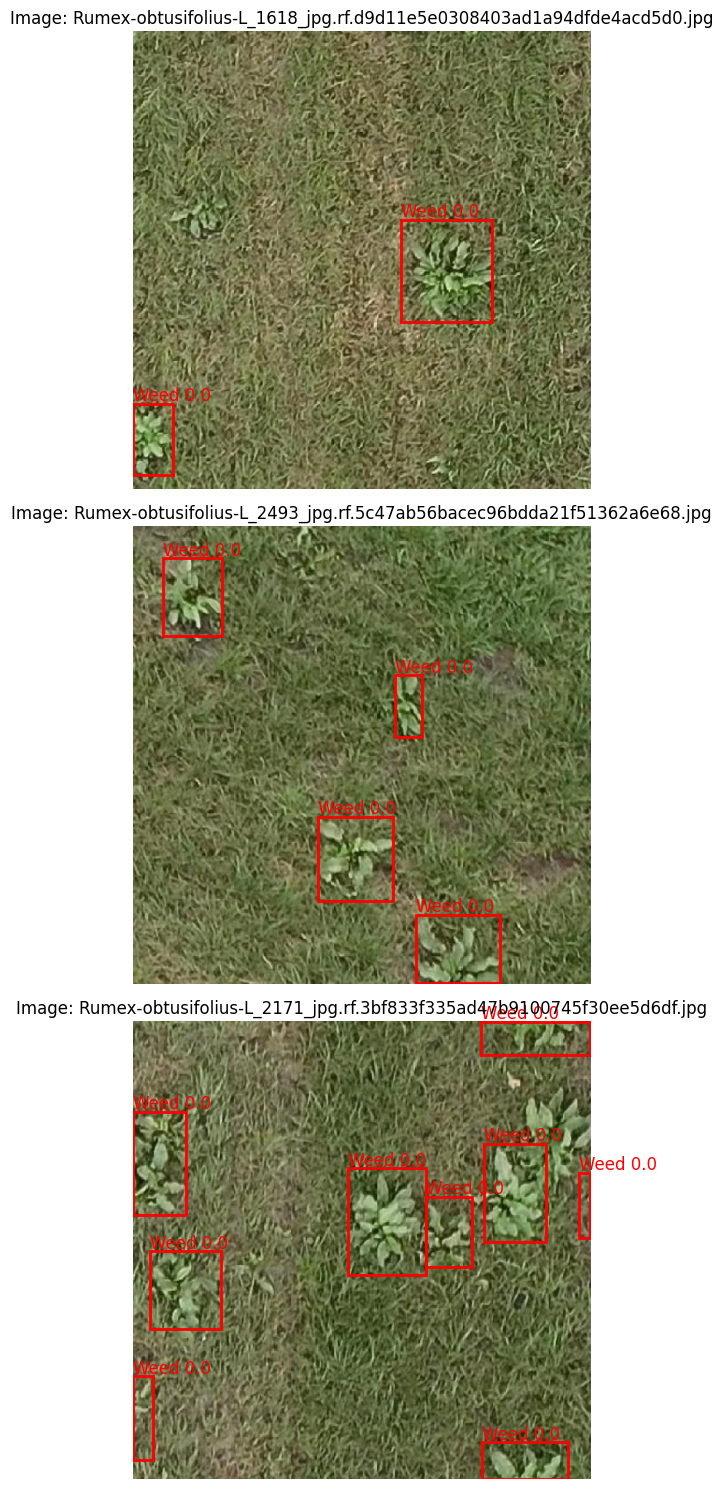

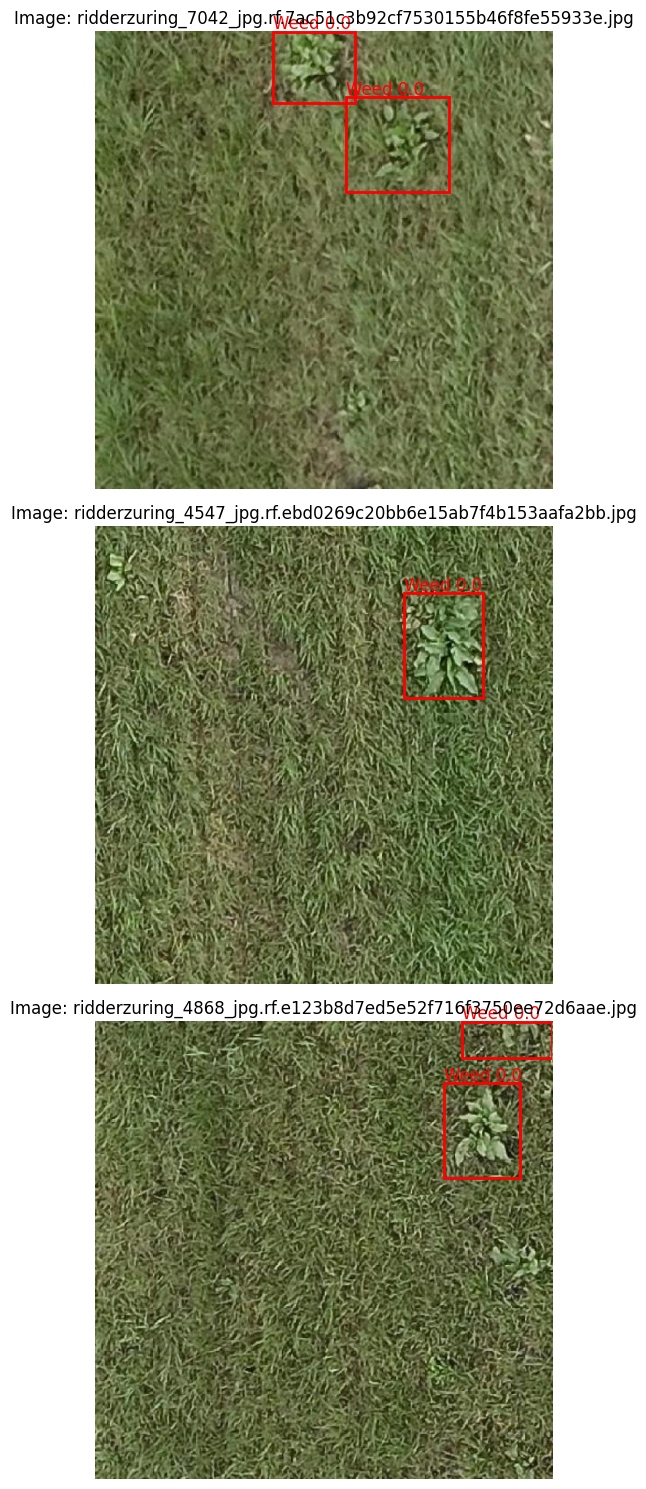

In [13]:
visualize_yolo_dataset('yolo_dataset/train')
visualize_yolo_dataset('yolo_dataset/test')

In [14]:
# Import required libraries
import numpy as np
import cv2
import os
import albumentations as A
import shutil

# Define augmentation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ], p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    ], p=0.5),
    A.OneOf([
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.Resize(height=640, width=640, p=0.5),
    ], p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Create augmented training directory
augmented_train_folder = os.path.join('yolo_dataset/train_with_aug')
os.makedirs(augmented_train_folder, exist_ok=True)

# First, copy all original files to the new directory
original_train_folder = os.path.join('yolo_dataset/train')
for file in os.listdir(original_train_folder):
    src = os.path.join(original_train_folder, file)
    dst = os.path.join(augmented_train_folder, file)
    shutil.copy2(src, dst)

# Get list of training images
image_files = [f for f in os.listdir(original_train_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
num_augmentations = 3  # Number of augmented versions to create per image

# Perform augmentation
for img_file in image_files:
    # Load image
    img_path = os.path.join(original_train_folder, img_file)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load corresponding label file
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(original_train_folder, label_file)
    
    if os.path.exists(label_path):
        # Read boxes and class labels
        boxes = []
        class_labels = []
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                boxes.append([x_center, y_center, width, height])
                class_labels.append(class_id)
        
        # Create augmented versions
        for i in range(num_augmentations):
            # Apply augmentation
            transformed = transform(image=image, bboxes=boxes, class_labels=class_labels)
            aug_image = transformed['image']
            aug_boxes = transformed['bboxes']
            
            # Save augmented image
            aug_img_file = f"{os.path.splitext(img_file)[0]}_aug_{i}{os.path.splitext(img_file)[1]}"
            aug_img_path = os.path.join(augmented_train_folder, aug_img_file)
            cv2.imwrite(aug_img_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            
            # Save augmented labels
            aug_label_file = f"{os.path.splitext(img_file)[0]}_aug_{i}.txt"
            aug_label_path = os.path.join(augmented_train_folder, aug_label_file)
            
            with open(aug_label_path, 'w') as f:
                for box, class_id in zip(aug_boxes, class_labels):
                    f.write(f"{int(class_id)} {' '.join(map(str, box))}\n")

# Print statistics
original_images = len(image_files)
total_images = len([f for f in os.listdir(augmented_train_folder) if f.endswith(('.jpg', '.jpeg', '.png'))])
augmented_images = total_images - original_images

print(f"Original training images: {original_images}")
print(f"Augmented images created: {augmented_images}")
print(f"Total training images available: {total_images}")


/tmp/ipykernel_88/2797659650.py:18: UserWarning: Argument 'var_limit' is not valid and will be ignored.
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),


Original training images: 1661
Augmented images created: 4965
Total training images available: 6626


In [15]:
# Obtenir le chemin absolu du projet
import os
current_dir = os.getcwd()

# Créer data.yaml avec les chemins absolus, incluant les données augmentées
data_yaml = {
    'train': os.path.join(current_dir, 'yolo_dataset/train_with_aug'), # new combined directory

        #os.path.join(current_dir, 'yolo_dataset/train'),          # données originales
    
    'val': os.path.join(current_dir, 'yolo_dataset/test'),        # chemin absolu vers test
    'nc': 1,  # nombre de classes
    'names': ['weed']  # nom des classes
}

# Écrire data.yaml
with open('yolo_dataset/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Vérifier le contenu du fichier
with open('yolo_dataset/data.yaml', 'r') as f:
    print(f.read())

names:
- weed
nc: 1
train: /notebooks/yolo_dataset/train_with_aug
val: /notebooks/yolo_dataset/test



In [16]:
# Vérifier le contenu du fichier data.yaml
with open('yolo_dataset/data.yaml', 'r') as f:
    content = yaml.safe_load(f)
    print("Configuration data.yaml:")
    print(f"- Train path: {content['train']}")
    print(f"- Val path: {content['val']}")
    print(f"- Number of classes: {content['nc']}")
    print(f"- Class names: {content['names']}")

Configuration data.yaml:
- Train path: /notebooks/yolo_dataset/train_with_aug
- Val path: /notebooks/yolo_dataset/test
- Number of classes: 1
- Class names: ['weed']


In [17]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cuda


## Model Training Section



In [22]:
# Check CUDA availability and GPU info
import torch
print(f"CUDA avail<able: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


import gc
gc.collect()
torch.cuda.empty_cache()


CUDA avail<able: True
Current device: 0
Device name: NVIDIA RTX A4000
Device memory: 16.89 GB


In [23]:
# Charger le modèle YOLOv8
model = YOLO("yolo11s.pt")  
INITIAL_LR = 0.01


# Entraîner le modèle
results = model.train(
    data='yolo_dataset/data.yaml',  # Chemin vers le fichier data.yaml
    epochs=60,                     # Nombre d'époques
    imgsz=640,                     # Taille des images
    batch=16,
    optimizer='AdamW',  # Better optimizer
    name='weed_detection',
    device=device,
    plots=True,       # Plot training results


)

100%|██████████| 18.4M/18.4M [00:00<00:00, 321MB/s]


Ultralytics 8.3.59 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=yolo_dataset/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=weed_detection2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /notebooks/yolo_dataset/train_with_aug.cache... 6620 images, 6 backgrounds, 0 corrupt: 100%|██████████| 6626/6626 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /notebooks/yolo_dataset/test.cache... 244 images, 1 backgrounds, 0 corrupt: 100%|██████████| 245/245 [00:00<?, ?it/s]


Plotting labels to runs/detect/weed_detection2/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/weed_detection2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.52G      1.977      1.701        1.7         15        640: 100%|██████████| 415/415 [01:06<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        245        662      0.586      0.483      0.513      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.53G      1.924      1.422      1.658         10        640: 100%|██████████| 415/415 [01:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

                   all        245        662      0.693      0.604      0.644      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.54G       1.85      1.359      1.612          3        640: 100%|██████████| 415/415 [01:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        245        662      0.646      0.665      0.661      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.56G      1.819      1.295      1.589          5        640: 100%|██████████| 415/415 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.79it/s]

                   all        245        662       0.66      0.598      0.606      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.54G      1.789      1.267      1.566          6        640: 100%|██████████| 415/415 [01:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.03it/s]

                   all        245        662      0.713      0.661      0.697      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.53G      1.766      1.236      1.542          8        640: 100%|██████████| 415/415 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]

                   all        245        662       0.75      0.654      0.711      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.51G      1.754      1.223      1.542         11        640: 100%|██████████| 415/415 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        245        662      0.696      0.665       0.67      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.56G      1.728       1.19      1.519          3        640: 100%|██████████| 415/415 [00:59<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]

                   all        245        662      0.714      0.672      0.691      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.53G      1.721      1.196      1.518          3        640: 100%|██████████| 415/415 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

                   all        245        662      0.716      0.689      0.717      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.55G      1.698      1.162      1.504          5        640: 100%|██████████| 415/415 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]

                   all        245        662      0.694      0.686      0.688      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.52G      1.701      1.159      1.509          9        640: 100%|██████████| 415/415 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.93it/s]

                   all        245        662      0.667      0.681      0.677      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.56G      1.701      1.153      1.504          2        640: 100%|██████████| 415/415 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.97it/s]

                   all        245        662      0.726      0.662       0.71      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.53G      1.682      1.141      1.488          7        640: 100%|██████████| 415/415 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]

                   all        245        662      0.694      0.709      0.722       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.55G      1.664      1.125      1.481         14        640: 100%|██████████| 415/415 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.06it/s]

                   all        245        662      0.692      0.666      0.698      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.51G      1.666      1.107      1.477          8        640: 100%|██████████| 415/415 [01:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]

                   all        245        662      0.686      0.693      0.695      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.56G      1.654      1.109      1.472          9        640: 100%|██████████| 415/415 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.92it/s]

                   all        245        662      0.675      0.672       0.68      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.54G      1.649      1.116      1.473         14        640: 100%|██████████| 415/415 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.90it/s]

                   all        245        662       0.71      0.657      0.706      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.55G      1.644      1.086      1.467          6        640: 100%|██████████| 415/415 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.88it/s]

                   all        245        662      0.681      0.654      0.682      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.52G      1.649      1.099      1.471          9        640: 100%|██████████| 415/415 [01:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.02it/s]

                   all        245        662      0.684      0.671      0.679      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      4.56G      1.625      1.075      1.452          9        640: 100%|██████████| 415/415 [00:59<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]

                   all        245        662      0.716      0.657      0.703      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.54G      1.626      1.077      1.457         12        640: 100%|██████████| 415/415 [00:59<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]

                   all        245        662      0.694      0.692      0.697      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.55G      1.617      1.071      1.455          4        640: 100%|██████████| 415/415 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        245        662      0.694      0.669      0.694      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.51G      1.609      1.059      1.454          8        640: 100%|██████████| 415/415 [01:03<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        245        662      0.726       0.68      0.724      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.56G      1.614      1.061      1.456          5        640: 100%|██████████| 415/415 [01:09<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        245        662       0.73      0.677      0.729      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.53G      1.613      1.069      1.458          7        640: 100%|██████████| 415/415 [01:04<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]

                   all        245        662      0.685      0.686      0.696      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.55G      1.592      1.058      1.439         11        640: 100%|██████████| 415/415 [01:07<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

                   all        245        662      0.711       0.68      0.709      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.51G      1.603      1.061      1.446          4        640: 100%|██████████| 415/415 [01:06<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

                   all        245        662      0.692      0.682      0.688       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.56G        1.6      1.065      1.442          7        640: 100%|██████████| 415/415 [01:05<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]

                   all        245        662      0.716      0.659      0.705      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.53G      1.581      1.039      1.429          9        640: 100%|██████████| 415/415 [01:08<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

                   all        245        662      0.689      0.668      0.704      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.55G      1.592      1.042      1.436          9        640: 100%|██████████| 415/415 [01:04<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]

                   all        245        662      0.745      0.654      0.709      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.51G      1.581      1.037       1.43          5        640: 100%|██████████| 415/415 [01:03<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        245        662      0.689      0.692      0.707      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.56G      1.584      1.035      1.431          1        640: 100%|██████████| 415/415 [01:08<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]

                   all        245        662      0.708      0.675      0.706      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.53G      1.578      1.035       1.43          3        640: 100%|██████████| 415/415 [01:04<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.84it/s]

                   all        245        662      0.711      0.708      0.724      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.55G      1.563      1.027      1.416          8        640: 100%|██████████| 415/415 [01:06<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        245        662      0.714      0.681      0.714      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.51G      1.569      1.026       1.42          6        640: 100%|██████████| 415/415 [01:05<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]

                   all        245        662      0.701        0.7      0.712      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.56G      1.567      1.024      1.423          4        640: 100%|██████████| 415/415 [01:03<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        245        662      0.703      0.691      0.701      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.53G      1.552      1.019       1.41          5        640: 100%|██████████| 415/415 [01:08<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]

                   all        245        662      0.689      0.699       0.71      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.56G      1.561      1.013      1.416         19        640: 100%|██████████| 415/415 [01:04<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

                   all        245        662      0.708      0.693      0.729      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.51G      1.551      1.005      1.413          3        640: 100%|██████████| 415/415 [01:07<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

                   all        245        662      0.691      0.693      0.697      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.56G      1.552      1.018      1.423          9        640: 100%|██████████| 415/415 [01:05<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        245        662      0.699      0.683      0.708      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.53G      1.539      1.007      1.409          8        640: 100%|██████████| 415/415 [01:03<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.88it/s]

                   all        245        662      0.708      0.694       0.72       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.55G      1.543      1.001        1.4          3        640: 100%|██████████| 415/415 [01:10<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

                   all        245        662      0.717      0.667      0.708      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.52G      1.522     0.9805      1.395         16        640: 100%|██████████| 415/415 [01:08<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.98it/s]

                   all        245        662      0.739      0.656      0.701      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.56G      1.529     0.9972      1.397          3        640: 100%|██████████| 415/415 [01:04<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.91it/s]

                   all        245        662      0.726      0.678      0.722      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.53G      1.529     0.9882      1.394          1        640: 100%|██████████| 415/415 [01:07<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.28it/s]


                   all        245        662      0.714      0.683      0.711       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.56G      1.521      0.984      1.393          8        640: 100%|██████████| 415/415 [01:05<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.89it/s]

                   all        245        662      0.712      0.671      0.706      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.51G      1.523     0.9913      1.394         20        640: 100%|██████████| 415/415 [01:05<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

                   all        245        662      0.709      0.688      0.708      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.53G        1.5     0.9595      1.378          3        640: 100%|██████████| 415/415 [01:08<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

                   all        245        662      0.702      0.693      0.709      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.54G        1.5     0.9585      1.382         12        640: 100%|██████████| 415/415 [01:05<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.96it/s]

                   all        245        662      0.718      0.678      0.709      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      4.56G      1.509     0.9856      1.389         13        640: 100%|██████████| 415/415 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.97it/s]

                   all        245        662      0.703      0.685      0.702       0.34


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.51G      1.497     0.9217      1.453          2        640: 100%|██████████| 415/415 [01:05<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]

                   all        245        662      0.731      0.678      0.719      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.56G       1.49     0.9141      1.446          3        640: 100%|██████████| 415/415 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        245        662      0.721      0.673      0.708      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.53G      1.487     0.9023      1.436          4        640: 100%|██████████| 415/415 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.14it/s]

                   all        245        662      0.735      0.647      0.704      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.55G      1.471     0.8973      1.426          3        640: 100%|██████████| 415/415 [01:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        245        662      0.729      0.667      0.704      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.51G      1.473     0.9074      1.424          0        640: 100%|██████████| 415/415 [01:00<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.09it/s]

                   all        245        662      0.714      0.686      0.711      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.56G      1.464     0.8912      1.428          5        640: 100%|██████████| 415/415 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.12it/s]

                   all        245        662      0.722      0.684      0.705      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.53G      1.463     0.8833      1.425          3        640: 100%|██████████| 415/415 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]

                   all        245        662      0.732      0.656      0.705      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.55G      1.455     0.8812      1.422          4        640: 100%|██████████| 415/415 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

                   all        245        662      0.727      0.674      0.703      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.51G      1.447     0.8812      1.412          4        640: 100%|██████████| 415/415 [00:59<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.51it/s]

                   all        245        662      0.711      0.681      0.707      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.56G       1.44     0.8742      1.415          7        640: 100%|██████████| 415/415 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.85it/s]

                   all        245        662      0.719      0.675      0.707      0.341



60 epochs completed in 1.087 hours.
Optimizer stripped from runs/detect/weed_detection2/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/weed_detection2/weights/best.pt, 19.2MB

Validating runs/detect/weed_detection2/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


                   all        245        662      0.709      0.694      0.729      0.357
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/weed_detection2


In [26]:
# Get the parent directory of the current working directory
parent_dir = os.path.dirname(os.getcwd())

# Navigate to runs/detect/weed_detection8 folder
target_dir = os.path.join('runs', 'detect', 'weed_detection2')

print(f"Target directory: {target_dir}")

# List contents of weed_detection8 directory if it exists
if os.path.exists(target_dir):
    print("\nContents of weed_detection8 directory:")
    for item in os.listdir(target_dir):
        print(f"- {item}")
else:
    print("\nDirectory not found. Please check if the path is correct.")


Target directory: runs/detect/weed_detection2

Contents of weed_detection8 directory:
- val_batch0_pred.jpg
- F1_curve.png
- events.out.tfevents.1736623285.njpqais1r3.88.2
- results.png
- R_curve.png
- val_batch1_labels.jpg
- train_batch20751.jpg
- train_batch20750.jpg
- confusion_matrix.png
- train_batch1.jpg
- labels.jpg
- args.yaml
- val_batch0_labels.jpg
- weights
- labels_correlogram.jpg
- PR_curve.png
- val_batch2_labels.jpg
- val_batch2_pred.jpg
- train_batch2.jpg
- train_batch20752.jpg
- P_curve.png
- confusion_matrix_normalized.png
- train_batch0.jpg
- val_batch1_pred.jpg
- results.csv


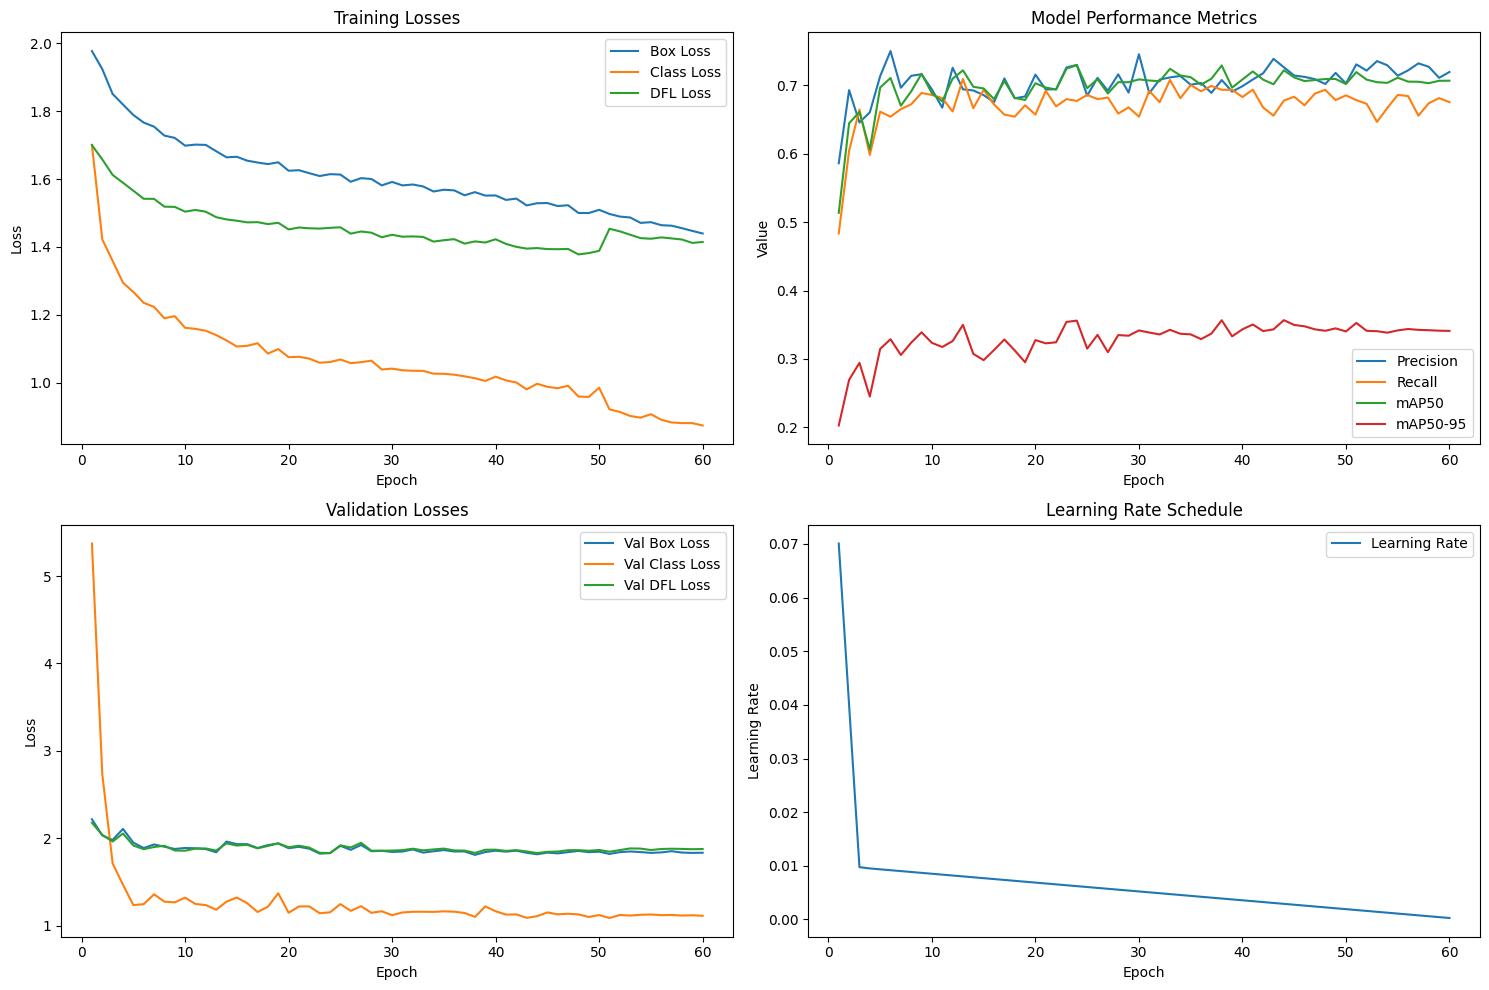


Final Model Performance:
Precision: 0.719
Recall: 0.675
mAP50: 0.707
mAP50-95: 0.341


In [27]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load and plot training results
results = pd.read_csv('runs/detect/weed_detection2/results.csv')

# Plot training metrics
plt.figure(figsize=(15, 10))

# Training Losses
plt.subplot(2, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='Box Loss')
plt.plot(results['epoch'], results['train/cls_loss'], label='Class Loss')
plt.plot(results['epoch'], results['train/dfl_loss'], label='DFL Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision, Recall, mAP
plt.subplot(2, 2, 2)
plt.plot(results['epoch'], results['metrics/precision(B)'], label='Precision')
plt.plot(results['epoch'], results['metrics/recall(B)'], label='Recall')
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50')
plt.plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95')
plt.title('Model Performance Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# Validation Losses
plt.subplot(2, 2, 3)
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss')
plt.plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss')
plt.plot(results['epoch'], results['val/dfl_loss'], label='Val DFL Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Learning Rate
plt.subplot(2, 2, 4)
plt.plot(results['epoch'], results['lr/pg0'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics summary
print("\nFinal Model Performance:")
print(f"Precision: {results['metrics/precision(B)'].iloc[-1]:.3f}")
print(f"Recall: {results['metrics/recall(B)'].iloc[-1]:.3f}")
print(f"mAP50: {results['metrics/mAP50(B)'].iloc[-1]:.3f}")
print(f"mAP50-95: {results['metrics/mAP50-95(B)'].iloc[-1]:.3f}")

### **Strengths**

1. **Precision (0.759):**
   - The model has a relatively high precision, indicating that when it predicts a weed, it is correct about 75.9% of the time. This is beneficial in applications where false positives (incorrectly identifying non-weeds as weeds) need to be minimized, such as in automated weed control systems where unnecessary actions could be costly or damaging.

2. **mAP50 (0.736):**
   - The mean Average Precision at an IoU threshold of 50% is 73.6%, which suggests that the model is quite effective at detecting and localizing weeds with a reasonable degree of overlap between predicted and actual bounding boxes. This is a positive indicator of the model's ability to identify most weeds accurately.

### **Weaknesses**

1. **Recall (0.656):**
   - The recall is lower than precision, at 65.6%, indicating that the model misses a significant number of actual weed instances. This suggests that the model could benefit from improvements in detecting all instances of weeds, especially smaller or less distinct ones.

2. **mAP50-95 (0.363):**
   - The mean Average Precision across a range of IoU thresholds (50% to 95%) is quite low at 36.3%. This indicates that while the model can detect weeds, the precision of the bounding boxes is not as high, especially under stricter IoU conditions. This suggests that the model struggles with accurately placing bounding boxes around weeds, which could be due to variability in weed shapes, sizes, or occlusions in the dataset.

### **Overall Performance Summary**

The model demonstrates a good balance between precision and recall, with a stronger emphasis on precision. However, the lower recall and mAP50-95 suggest that there is room for improvement in detecting all weed instances and refining the accuracy of bounding box placements. Potential areas for improvement could include:

- **Data Augmentation:** Enhance the training dataset with more diverse augmentations to help the model generalize better to unseen data.
- **Model Architecture:** Experiment with more complex architectures or fine-tuning pre-trained models to improve detection capabilities.
- **Hyperparameter Tuning:** Adjust training parameters such as learning rate, batch size, and number of epochs to optimize model performance.
- **Additional Data:** Incorporate more training data, especially for underrepresented weed types or challenging conditions, to improve recall and bounding box precision. 

Overall, while the model shows promise, particularly in precision, further refinements could enhance its ability to detect and accurately localize all weed instances.


# Visualizing Training Results and Model Performance Metrics
We will now plot various visualizations generated during model training, including:
- Confusion matrices (normalized and raw) to evaluate classification performance
- Validation batch predictions and ground truth labels
- Training batch samples showing model's learning progress
- Performance curves (P, R, F1, PR curves) to assess model metrics
- Label statistics and correlations
These plots help us analyze the model's behavior and validate its performance on our weed detection task.








In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# List of image files to plot (excluding non-image files)
image_files = [
    'confusion_matrix.png',
    'val_batch1_labels.jpg', 
    'results.png',
    'P_curve.png',
    'val_batch2_pred.jpg',
    'labels_correlogram.jpg', 
    'train_batch4161.jpg',
    'train_batch4160.jpg',
    'train_batch4162.jpg',
    'val_batch0_labels.jpg',
    'F1_curve.png',
    'train_batch0.jpg',
    'train_batch1.jpg',
    'confusion_matrix_normalized.png',
    'train_batch2.jpg',
    'val_batch1_pred.jpg',
    'val_batch0_pred.jpg',
    'R_curve.png',
    'labels.jpg',
    'val_batch2_labels.jpg',
    'PR_curve.png'
]

# Create a figure with subplots
n_images = len(image_files)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols

plt.figure(figsize=(20, 5*n_rows))

# Plot each image
for i, img_file in enumerate(image_files):
    img_path = os.path.join(target_dir, img_file)
    if os.path.exists(img_path):
        plt.subplot(n_rows, n_cols, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')
    else:
        print(f"File not found: {img_path}")

plt.tight_layout()
plt.show()
